In [ ]:
# Imports
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers
import huggingface_hub
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# Configurations
PROJECT_PATH = 'D:\Documents\Kiwibot\depth-estimation-project'
USEFUL_CAMERAS = [['/video_mapping/left','/video_mapping/left/depth_map'],['/video_mapping/right', '/video_mapping/right/depth_map'], ['/video_mapping/back', '/video_mapping/back/depth_map'],['/camera/color/image_raw', '/camera/color/image_raw/depth_map']]

## Metrics

For the evaluation of models, the following evaluation metrics were chosen:
* IoU (Intersection over Union)
* Dice Coefficient (F1 Score)
* Prediction Time

## Input Data Pipeline

### Tensorflow

In [ ]:
# Making the data pipeline for tensorflow

metadata_path = os.path.join(PROJECT_PATH,'data','metadata.csv')
metadata = pd.read_csv(metadata_path, encoding='utf-8')
metadata.head()

In [ ]:
images_list = []
depth_masks_list = []

for camera in USEFUL_CAMERAS:
    images_camera = metadata[camera[0]].tolist()
    masks_camera = metadata[camera[1]].tolist()

    images_path = [os.path.join(PROJECT_PATH,'data','lidar-cams-dataset',x) for x in images_camera]
    masks_path = [os.path.join(PROJECT_PATH,'data','lidar-cams-dataset',x) for x in masks_camera]

    images_list = images_list + images_path
    depth_masks_list = depth_masks_list + masks_path

In [ ]:
# Check out some images
fig, ax = plt.subplots(4, 2, figsize=(14, 15))

for i in range(4):
    N = random.randint(0, len(images_list))

    img = cv2.imread(images_list[N])[:,:,::-1]
    mask = cv2.imread(depth_masks_list[N],0)

    ax[i,0].imshow(img)
    ax[i,0].set_title('Image')
    ax[i,1].imshow(mask, cmap='plasma')
    ax[i,1].set_title('LIDAR Depth')

plt.show()

In [136]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(depth_masks_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [137]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    depth_mask = tf.io.read_file(mask_path)
    depth_mask = tf.image.decode_png(depth_mask, channels=1)

    mask = tf.equal(depth_mask, tf.zeros_like(depth_mask))
    mask = tf.logical_not(mask)

    masked_img = tf.multiply(mask.astype(tf.float32),img)

    return masked_img, depth_mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='bilinear')
    input_mask = tf.image.resize(mask, (256, 256), method='bilinear')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
for data in processed_image_ds.take(1):
    fig, arr = plt.subplots(1, 2, figsize=(14, 10))
    arr[0].imshow(data[0])
    arr[0].set_title('Image')
    arr[1].imshow(data[1])
    print(data[0].shape)
    print(data[1].shape)
    arr[1].set_title('Segmentation')

### Pytorch

In [ ]:
# Making the data pipeline with Pytorch

## Simple U-Net

In [ ]:
class DownscaleBlock(layers.Layer):
    def __init__(
            self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
            self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
            self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [ ]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 10

In [ ]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
                (self.ssim_loss_weight * ssim_loss)
                + (self.l1_loss_weight * l1_loss)
                + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model2 = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model2.compile(optimizer, loss=cross_entropy)

In [ ]:
model_history = model2.fit(
    batched_train,
    epochs=EPOCHS,
    validation_data=batched_val,
)

## U-Net with convolutional backbone

First an inte

In [ ]:
LR = 0.0002
BATCH_SIZE = 10
EPOCHS = 30

In [ ]:
# Import model
model = huggingface_hub.from_pretrained_keras("keras-io/monocular-depth-estimation")

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)#, reduction="none")

# Compile the model
model.compile(optimizer, loss=cross_entropy)

In [138]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=0)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [139]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(processed_image_ds,len(processed_image_ds))

In [140]:
batched_train = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_val = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_test = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model_history = model.fit(
    batched_train,
    epochs=EPOCHS,
    validation_data=batched_val,
)

In [141]:
for image, mask in batched_train.take(1):
    pred_mask = model2.predict(image)
    tensor_pred_mask = tf.convert_to_tensor(pred_mask)
    hola_mask = mask

1/1 [==============================] - 0s 24ms/step


In [142]:
hola_mask2 = hola_mask[0].numpy().squeeze()

In [129]:
sad = cv2.imread(depth_masks_list[N],0)

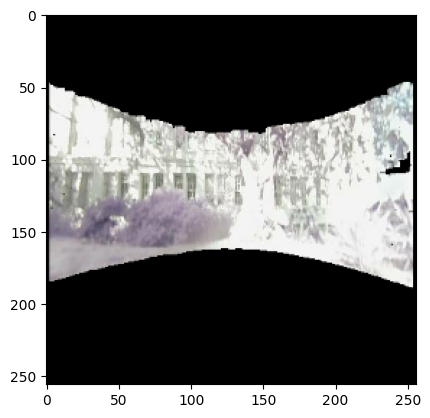

In [144]:
plt.imshow(image[0].numpy().squeeze())

## References
* [Monocular Depth Estimation Using Deep Learning: A Review](https://www.mdpi.com/1424-8220/22/14/5353/pdf?version=1658138962)
* [Depth Estimation - Papers with code](https://paperswithcode.com/task/depth-estimation)
* [High Quality Monocular Depth Estimation via Transfer Learning](https://arxiv.org/pdf/1812.11941.pdf)
* [Keras tutorial - Depth Estimation](https://keras.io/examples/vision/depth_estimation/)
* [Vision Transformers for Dense Prediction - Code](https://github.com/isl-org/DPT)
* [Vision Transformers for Dense Prediction - Paper](https://arxiv.org/pdf/2103.13413.pdf)
* [DPT Large model in Hugging Face](https://huggingface.co/Intel/dpt-large)